<a href="https://colab.research.google.com/github/aalvaradog/Proyecto2IA/blob/main/ModeloA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wandb
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from sklearn.preprocessing import LabelEncoder
from keras.datasets import cifar10
from keras.utils import to_categorical
import keras.utils
import numpy as np
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image


# Cargar datos crudos

In [ ]:
# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data/raw/training_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_training = np.array(images)
labels_training = np.array(labels)

# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data/raw/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_testing = np.array(images)
labels_testing = np.array(labels)

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
#1=normal, 0=covid, 2=pneumonia
encoded_train = label_encoder.fit_transform(labels_training)

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
encoded_test = label_encoder.fit_transform(labels_testing)


#1=normal,0=covid,2=vp
#print(labels)
#print(encoded_test)


# Datos crudos

In [ ]:
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "47f2aef305ac01e91a0eaa99a28fe0778413938f"
wandb.login()

class_names = ["Normal", "Covid", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
)

# Cargar el modelo pre-entrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas convolucionales para que los pesos no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

# One-hot encode the target arrays
y_train_onehot = keras.utils.to_categorical(encoded_train, num_classes=3)
y_test_onehot = keras.utils.to_categorical(encoded_test, num_classes=3)


start_time = time.time()

# Entrenamiento del modelo
for epoch in range(10):
    # Entrenar el modelo para una época
    history = model.fit(img_training, y_train_onehot, batch_size=32, epochs=1, validation_split=0.2)

    # Registrar las métricas de entrenamiento en Wandb
    wandb.log({"Train Loss": history.history['loss'][0], "Train Acc": (history.history['accuracy'][0])*100,
               "Epoch": epoch,"Elapsed time:":time.time() - start_time})

    # Evaluar el modelo
    loss, accuracy = model.evaluate(img_testing, y_test_onehot)
    print("Accuracy:", accuracy)

    # Registrar los resultados en Wandb
    wandb.log({"Valid Loss": loss,
              "Valid Acc": accuracy*100 })

# Obtener predicciones
predictions = model.predict(img_testing)

# Convert predictions to 1-dimensional array
predicted_classes = np.argmax(predictions, axis=1)

lista_true=encoded_test.tolist()
lista_predic=predicted_classes.tolist()


# Registrar también las métricas de entrenamiento
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=lista_true,
                                                                preds=lista_predic,
                                                                class_names=class_names,
                                                                title = "Raw Confusion Matrix")},
                                                                commit=False)



wandb: Currently logged in as: aalvaradog99 (sebas1498). Use `wandb login --relogin` to force relogin


11/11 [==============================] - 2s 162ms/step - loss: 0.7173 - accuracy: 0.7737
Accuracy: 0.7737002968788147
11/11 [==============================] - 0s 39ms/step - loss: 0.5557 - accuracy: 0.7951
Accuracy: 0.7951070070266724
11/11 [==============================] - 0s 39ms/step - loss: 0.4069 - accuracy: 0.9052
Accuracy: 0.9051987528800964
11/11 [==============================] - 0s 39ms/step - loss: 0.5162 - accuracy: 0.7859
Accuracy: 0.785932719707489
11/11 [==============================] - 0s 39ms/step - loss: 0.3724 - accuracy: 0.8502
Accuracy: 0.8501529097557068
11/11 [==============================] - 0s 39ms/step - loss: 0.3138 - accuracy: 0.8746
Accuracy: 0.8746177554130554
11/11 [==============================] - 0s 39ms/step - loss: 0.3532 - accuracy: 0.8471
Accuracy: 0.8470947742462158
11/11 [==============================] - 0s 39ms/step - loss: 0.2607 - accuracy: 0.9083
Accuracy: 0.9082568883895874
11/11 [==============================] - 0s 40ms/step - loss: 0.

# Cargar datos bilateral

In [ ]:
# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data/bilateralFilter/training_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_training = np.array(images)
labels_training = np.array(labels)

# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data/bilateralFilter/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_testing = np.array(images)
labels_testing = np.array(labels)

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
#1=normal, 0=covid, 2=pneumonia
encoded_train = label_encoder.fit_transform(labels_training)

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
encoded_test = label_encoder.fit_transform(labels_testing)


# Datos con filtro bilateral

In [ ]:

# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "47f2aef305ac01e91a0eaa99a28fe0778413938f"
wandb.login()

class_names = ["Normal", "Covid", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
)

# Cargar el modelo pre-entrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas convolucionales para que los pesos no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

# One-hot encode the target arrays
y_train_onehot = keras.utils.to_categorical(encoded_train, num_classes=3)
y_test_onehot = keras.utils.to_categorical(encoded_test, num_classes=3)


start_time = time.time()

# Entrenamiento del modelo
for epoch in range(10):
    # Entrenar el modelo para una época
    history = model.fit(img_training, y_train_onehot, batch_size=32, epochs=1, validation_split=0.2)

    # Registrar las métricas de entrenamiento en Wandb
    wandb.log({"Train Loss": history.history['loss'][0], "Train Acc": (history.history['accuracy'][0]) * 100,
               "Epoch": epoch,"Elapsed time:":time.time() - start_time})

    # Evaluar el modelo
    loss, accuracy = model.evaluate(img_testing, y_test_onehot)
    print("Accuracy:", accuracy)

    # Registrar los resultados en Wandb
    wandb.log({"Valid Loss": loss,
              "Valid Acc": accuracy*100})

# Obtener predicciones
predictions = model.predict(img_testing)

# Convert predictions to 1-dimensional array
predicted_classes = np.argmax(predictions, axis=1)

lista_true=encoded_test.tolist()
lista_predic=predicted_classes.tolist()

# Registrar también las métricas de entrenamiento
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=lista_true,
                                                                preds=lista_predic,
                                                                class_names=class_names,
                                                                title = "Bilateral Confusion Matrix")},
                                                                commit=False)



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Elapsed time:,▁▂▃▄▅▅▆▇▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▆▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Valid Acc,▁▃▅▄▅▅▆▅█▇
Valid Loss,█▅▄▃▂▂▂▂▁▁
Elapsed time:,42.57065
Epoch,9
Train Acc,96.39304
Train Loss,0.13832
Valid Acc,91.91919


13/13 [==============================] - 1s 38ms/step - loss: 0.7977 - accuracy: 0.6717
Accuracy: 0.6717171669006348
13/13 [==============================] - 1s 39ms/step - loss: 0.5061 - accuracy: 0.8258
Accuracy: 0.8257575631141663
13/13 [==============================] - 1s 39ms/step - loss: 0.4430 - accuracy: 0.8460
Accuracy: 0.8459596037864685
13/13 [==============================] - 1s 39ms/step - loss: 0.4231 - accuracy: 0.8182
Accuracy: 0.8181818127632141
13/13 [==============================] - 1s 39ms/step - loss: 0.3500 - accuracy: 0.8586
Accuracy: 0.8585858345031738
13/13 [==============================] - 1s 38ms/step - loss: 0.3258 - accuracy: 0.8636
Accuracy: 0.8636363744735718
13/13 [==============================] - 1s 39ms/step - loss: 0.3388 - accuracy: 0.8510
Accuracy: 0.8510100841522217
13/13 [==============================] - 1s 43ms/step - loss: 0.2401 - accuracy: 0.9242
Accuracy: 0.9242424368858337
13/13 [==============================] - 1s 41ms/step - loss: 0.

# Cargar datos canny

In [ ]:
# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data/cannyFilter/training_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_training = np.array(images)
labels_training = np.array(labels)

# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data/cannyFilter/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_testing = np.array(images)
labels_testing = np.array(labels)

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
#1=normal, 0=covid, 2=pneumonia
encoded_train = label_encoder.fit_transform(labels_training)

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
encoded_test = label_encoder.fit_transform(labels_testing)

# Datos con filtro canny

In [ ]:
# Set your API key as an environment variable para wandb
os.environ["WANDB_API_KEY"] = "47f2aef305ac01e91a0eaa99a28fe0778413938f"
wandb.login()

class_names = ["Normal", "Covid", "Viral Pneumonia"]

# Parametros para inicializar Wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="Proyecto2",
)

# Cargar el modelo pre-entrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas convolucionales para que los pesos no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

# One-hot encode the target arrays
y_train_onehot = keras.utils.to_categorical(encoded_train, num_classes=3)
y_test_onehot = keras.utils.to_categorical(encoded_test, num_classes=3)


start_time = time.time()

# Entrenamiento del modelo
counter=0
for epoch in range(10):
    # Entrenar el modelo para una época
    history = model.fit(img_training, y_train_onehot, batch_size=32, epochs=1, validation_split=0.2)

    # Registrar las métricas de entrenamiento en Wandb
    wandb.log({"Train Loss": history.history['loss'][0],"Train Acc": (history.history['accuracy'][0] )*100,
               "Epoch": counter,"Elapsed time:":time.time() - start_time})

    # Evaluar el modelo
    loss, accuracy = model.evaluate(img_testing, y_test_onehot)
    print("Accuracy:", accuracy)

    # Registrar los resultados en Wandb
    wandb.log({"Valid Loss": loss,
              "Valid Acc": accuracy*100})
    counter=counter+1

# Obtener predicciones
predictions = model.predict(img_testing)

# Convert predictions to 1-dimensional array
predicted_classes = np.argmax(predictions, axis=1)

lista_true=encoded_test.tolist()
lista_predic=predicted_classes.tolist()

# Registrar también las métricas de entrenamiento
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                                y_true=lista_true,
                                                                preds=lista_predic,
                                                                class_names=class_names,
                                                                title = "Canny Confusion Matrix")},
                                                                commit=False)



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Elapsed time:,▁▂▃▄▄▅▆▇▇█
Epoch,▁▂▃▃▄▅▆▆▇█
Train Acc,▁▆▆▇▇▇████
Train Loss,█▅▃▃▂▂▂▁▁▁
Valid Acc,▁▂▇▂▄▆▄▇█▆
Valid Loss,█▆▄▅▃▂▃▁▁▂
Elapsed time:,50.10883
Epoch,9
Train Acc,94.70588
Train Loss,0.19857
Valid Acc,87.46178


13/13 [==============================] - 1s 117ms/step - loss: 2.8034 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 39ms/step - loss: 4.2086 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 38ms/step - loss: 4.4324 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 39ms/step - loss: 4.1000 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 39ms/step - loss: 3.7501 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 40ms/step - loss: 3.5306 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 41ms/step - loss: 3.6112 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 40ms/step - loss: 3.7782 - accuracy: 0.2850
Accuracy: 0.2849740982055664
13/13 [==============================] - 1s 39ms/step - loss: 3

# Saliency maps


In [ ]:
# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data2/raw/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_training = np.array(images)
labels_training = np.array(labels)

# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data2/raw/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_testing = np.array(images)
labels_testing = np.array(labels)

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
#1=normal, 0=covid, 2=pneumonia
encoded_train = label_encoder.fit_transform(labels_training)

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
encoded_test = label_encoder.fit_transform(labels_testing)

In [ ]:
# Callback para calcular los Saliency Maps y mostrar la imagen original, el Saliency Map y la etiqueta de clase
class SaliencyMapCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        for i in range(len(img_testing)):
            image = img_testing[i]
            label = labels_testing[i]
            saliency_map = self.calculate_saliency_map(image)
            self.plot_saliency_map(image, saliency_map, epoch, label)

    def calculate_saliency_map(self, img):
        img_tensor = tf.convert_to_tensor(img.reshape(1, 128, 128, 3), dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            predictions = self.model(img_tensor)
            top_prediction = tf.argmax(predictions[0])
            loss = predictions[0][top_prediction]
        gradients = tape.gradient(loss, img_tensor)
        saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)[0].numpy()
        return saliency_map

    def plot_saliency_map(self, image, saliency_map, epoch, label):
        # Plotear la imagen original, el saliency map y la superposición
        fig, axes = plt.subplots(1, 3, figsize=(15, 3))

        axes[0].imshow(image)
        axes[0].set_title(label)
        axes[0].axis('off')

        axes[1].imshow(saliency_map, cmap='jet')
        axes[1].set_title('Saliency Map')
        axes[1].axis('off')

        axes[2].imshow(image)
        axes[2].imshow(saliency_map, cmap='jet', alpha=0.6)
        axes[2].set_title('Overlay')
        axes[2].axis('off')

        plt.show()

1/1 [==============================] - ETA: 0s - loss: 1.6670 - accuracy: 0.0000e+00

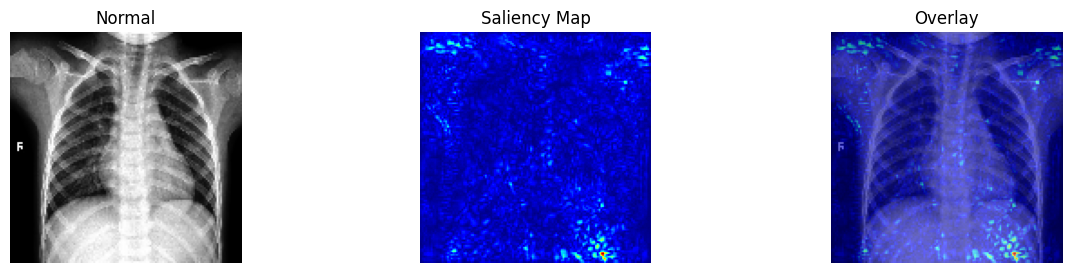

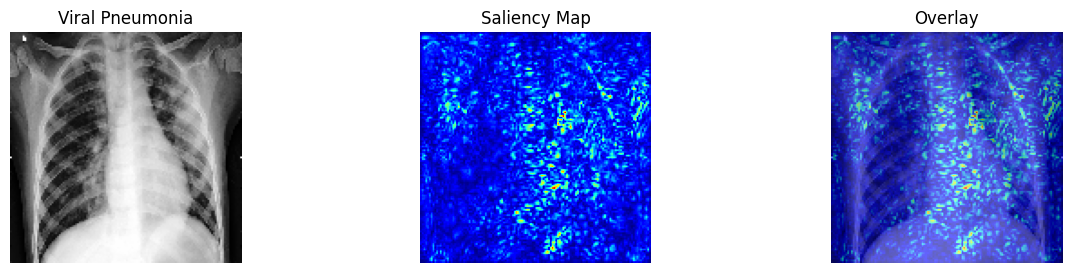

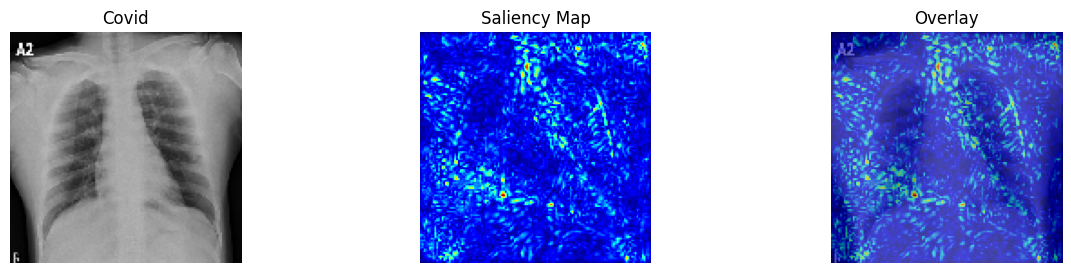

1/1 [==============================] - 6s 6s/step - loss: 1.6670 - accuracy: 0.0000e+00 - val_loss: 0.7581 - val_accuracy: 1.0000


1/1 [==============================] - 0s 51ms/step - loss: 1.0185 - accuracy: 0.3333
Accuracy: 0.3333333432674408


In [ ]:
# Cargar el modelo pre-entrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas convolucionales para que los pesos no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

# One-hot encode the target arrays
y_train_onehot = keras.utils.to_categorical(encoded_train, num_classes=3)
y_test_onehot = keras.utils.to_categorical(encoded_test, num_classes=3)


start_time = time.time()

# Entrenamiento del modelo
for epoch in range(1):
    # Entrenar el modelo para una época
    history = model.fit(img_training, y_train_onehot, batch_size=32, epochs=1, validation_split=0.2, callbacks=[SaliencyMapCallback()])

# Obtener predicciones
predictions = model.predict(img_training)

# Convert predictions to 1-dimensional array
predicted_classes = np.argmax(predictions, axis=1)

lista_true=encoded_train.tolist()
lista_predic=predicted_classes.tolist()


# Evaluar el modelo
loss, accuracy = model.evaluate(img_testing, y_test_onehot)
print("Accuracy:", accuracy)


# Saliency maps del bilateral

In [ ]:
# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data2/bilateralFilter/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_training = np.array(images)
labels_training = np.array(labels)

# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data2/bilateralFilter/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_testing = np.array(images)
labels_testing = np.array(labels)

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
#1=normal, 0=covid, 2=pneumonia
encoded_train = label_encoder.fit_transform(labels_training)

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
encoded_test = label_encoder.fit_transform(labels_testing)

1/1 [==============================] - ETA: 0s - loss: 1.2849 - accuracy: 0.5000

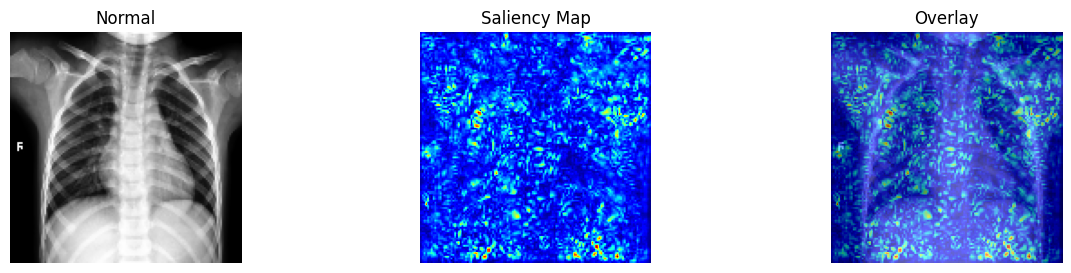

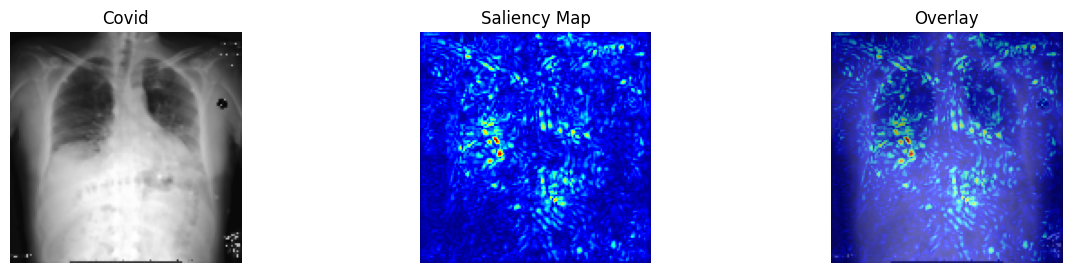

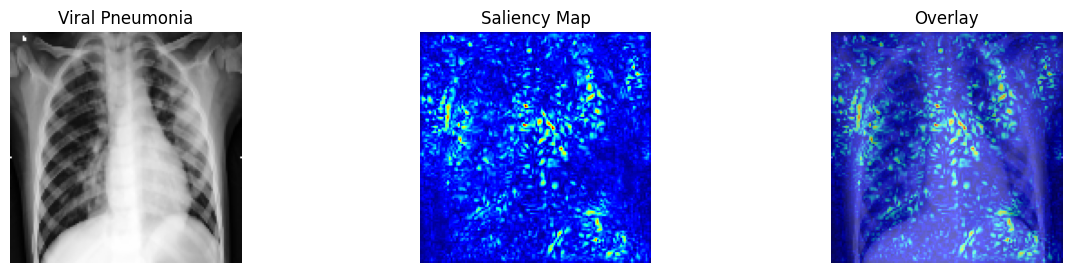

1/1 [==============================] - 0s 46ms/step - loss: 1.1823 - accuracy: 0.3333
Accuracy: 0.3333333432674408


In [ ]:
# Cargar el modelo pre-entrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas convolucionales para que los pesos no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

# One-hot encode the target arrays
y_train_onehot = keras.utils.to_categorical(encoded_train, num_classes=3)
y_test_onehot = keras.utils.to_categorical(encoded_test, num_classes=3)


start_time = time.time()

# Entrenamiento del modelo
for epoch in range(1):
    # Entrenar el modelo para una época
    history = model.fit(img_training, y_train_onehot, batch_size=32, epochs=1, validation_split=0.2, callbacks=[SaliencyMapCallback()])

# Obtener predicciones
predictions = model.predict(img_training)

# Convert predictions to 1-dimensional array
predicted_classes = np.argmax(predictions, axis=1)

lista_true=encoded_train.tolist()
lista_predic=predicted_classes.tolist()


# Evaluar el modelo
loss, accuracy = model.evaluate(img_testing, y_test_onehot)
print("Accuracy:", accuracy)

# Saliency maps canny

In [ ]:
# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data2/cannyFilter/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_training = np.array(images)
labels_training = np.array(labels)

# Definir la ruta de la carpeta que contiene las imágenes
folder_path = '/content/drive/MyDrive/DatosIA/Data2/cannyFilter/test_set'
# Listar todas las carpetas en la ruta especificada
subfolders = os.listdir(folder_path)

# Listas para almacenar las imágenes y las etiquetas
images = []
labels = []

# Cargar las imágenes y las etiquetas
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, file)
        image = load_img(image_path, target_size=(128, 128))
        image = img_to_array(image) / 255.0  # Normalizar la imagen
        images.append(image)
        labels.append(subfolder)

# Convertir listas a arrays numpy
img_testing = np.array(images)
labels_testing = np.array(labels)

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
#1=normal, 0=covid, 2=pneumonia
encoded_train = label_encoder.fit_transform(labels_training)

# Ajustar el LabelEncoder a las etiquetas y transformarlas en números
encoded_test = label_encoder.fit_transform(labels_testing)

1/1 [==============================] - ETA: 0s - loss: 0.9995 - accuracy: 0.5000

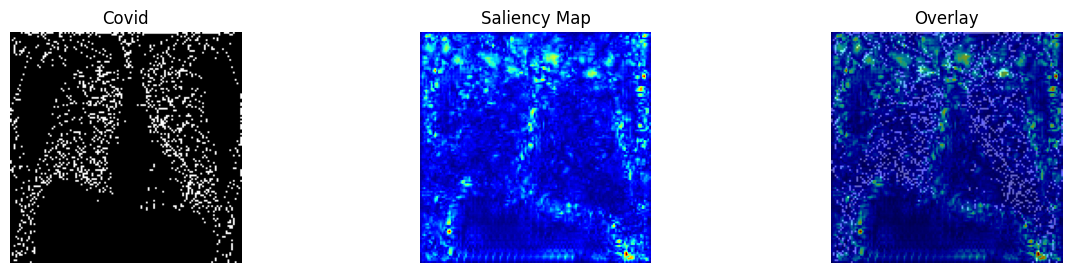

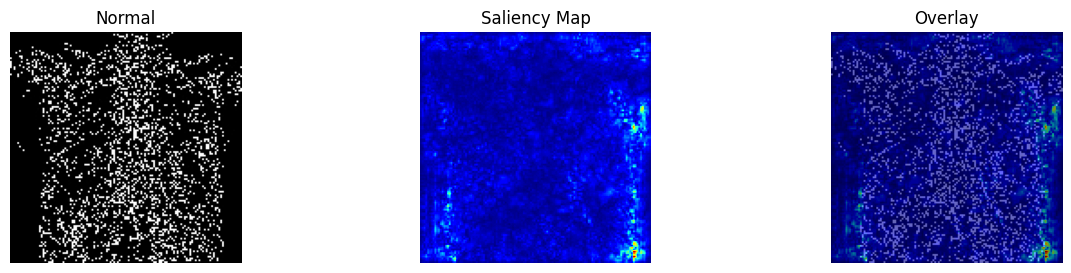

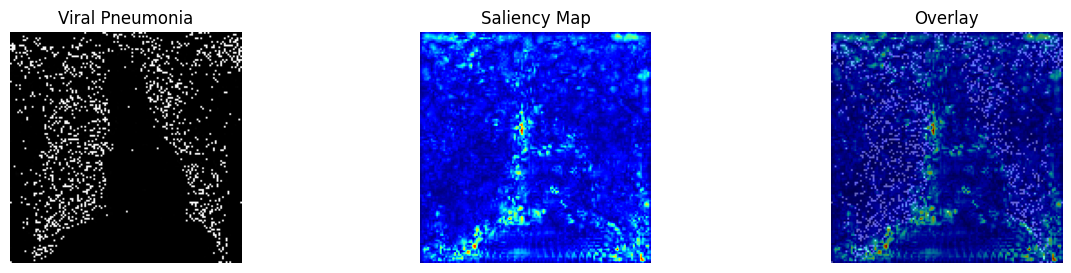

1/1 [==============================] - 0s 37ms/step - loss: 1.1123 - accuracy: 0.6667
Accuracy: 0.6666666865348816


In [ ]:
# Cargar el modelo pre-entrenado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas convolucionales para que los pesos no se actualicen durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para la clasificación
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

# One-hot encode the target arrays
y_train_onehot = keras.utils.to_categorical(encoded_train, num_classes=3)
y_test_onehot = keras.utils.to_categorical(encoded_test, num_classes=3)


start_time = time.time()

# Entrenamiento del modelo
for epoch in range(1):
    # Entrenar el modelo para una época
    history = model.fit(img_training, y_train_onehot, batch_size=32, epochs=1, validation_split=0.2, callbacks=[SaliencyMapCallback()])

# Obtener predicciones
predictions = model.predict(img_training)

# Convert predictions to 1-dimensional array
predicted_classes = np.argmax(predictions, axis=1)

lista_true=encoded_train.tolist()
lista_predic=predicted_classes.tolist()


# Evaluar el modelo
loss, accuracy = model.evaluate(img_testing, y_test_onehot)
print("Accuracy:", accuracy)